# Grape V1 Data Plots
The purpose of this notebook is to provide a one-stop shop for plotting data from the prototype of the Grape 1 Low-Cost Personal Space Weather Station. 

This notebook was created by Kristina Collins KD8OXT. Code was contributed by Aidan Montare KB3UMD, Bob Benedict KD8CGH, and Nathaniel Frissell W2NAF. Hardware designed by John Gibbons. Node maintainers are listed in the `nodelist.csv` file which accompanies this notebook.

## Instructions:
Data is permanently stored at [![DOI](https://zenodo.org/badge/DOI/10.5281/zenodo.6622112.svg)](https://doi.org/10.5281/zenodo.6622112). To use this notebook, download the data from the repository and unzip it into the `data/` directory.

In [1]:
import os
import sys
import glob
import datetime
import pytz

import numpy as np
import pandas as pd
import csv

# import seaborn as sns; sns.set_theme()
import plotly.express as px
import plotly.graph_objects as go

import matplotlib as mpl
import matplotlib.pyplot as plt

import locator
from Beacon import readheader                                     # local .py file

from scipy.signal import filtfilt, butter
from suntime import Sun
from WWV_utility2 import time_string_to_decimals                              # python file in this directory
from Beacon import readheader

from dateutil import parser                                                   # used in multiplot()

In [2]:
# mpl.rcParams

In [3]:
mpl.rcParams['font.size']        = 16
mpl.rcParams['font.weight']      = 'bold'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.grid']        = True
mpl.rcParams['grid.linestyle']   = ':'
mpl.rcParams['figure.figsize']   = np.array([15, 8])
mpl.rcParams['axes.xmargin']     = 0

# Generate Data Overview
The first step is to pull the list of filenames from the server maintained by the WWV Amateur Radio Club, WW0WWV. We will then generate a pandas dataframe from the filename list using the split() function. This will tell us the earliest and latest dates of data collection; we can use these as the bounds of our analysis, or substitute in a smaller set of bounds. We'll use this to create a Data Inventory (Gantt chart) showing station availability, and maybe keograms of our data over time. While we're at it, we can also generate two versions of a station map: one static, to put in our paper; and one dynamic, showing which stations were active at a given point in time. 

## Load and Parse Filenames

In [4]:
mypath = 'data/' # Path of data files.

# Load filenames and create a dataframe.
fpaths = glob.glob(os.path.join(mypath,'*.csv'))
bnames = [os.path.basename(fpath) for fpath in fpaths]
df = pd.DataFrame({'Filename':bnames})

# Parse filenames into useful information and place into dataframe.
df2              = df['Filename'].str.split('_', expand=True)
df2.columns      =['Datetime', 'Node', 'G', 'Grid Square', 'FRQ', 'Frequency']
df2              = df2.drop(columns=['FRQ']) # no information in this columnn
df2["Frequency"] = df2["Frequency"].str.strip('.csv')

# # Parse Grid Squares
# lat,lon = locator.gridsquare2latlon(df2['Grid Square'])
# df2['Latitude']  = lat
# df2['Longitude'] = lon

df               = pd.concat([df2, df], axis = 1) # concatenate dataframes horizontally
df['Datetime']   = pd.to_datetime(df['Datetime']) # cast to datetime
df['Node']       = df['Node'].str.strip("N")                   # Ditch the leading N on the node numbers
df['Node']       = df['Node'].astype(str).astype(int)          # Cast node number to int
df               = df[~df['Frequency'].str.contains('G1')]     # discarding files with naming errors

# Convert frequency abbreviations to numbers:
df.loc[df['Frequency'] == 'WWV5',    'Frequency'] = 5e6
df.loc[df['Frequency'] == 'WWV10',   'Frequency'] = 10e6
df.loc[df['Frequency'] == 'WWV2p5',  'Frequency'] = 2.5e6
df.loc[df['Frequency'] == 'WWV15',   'Frequency'] = 15e6
df.loc[df['Frequency'] == 'CHU3',    'Frequency'] = 3330e3
df.loc[df['Frequency'] == 'CHU7',    'Frequency'] = 7850e3
df.loc[df['Frequency'] == 'CHU14',   'Frequency'] = 14.67e6
df.loc[df['Frequency'] == 'Unknown', 'Frequency'] = 0

df

Datetime  Node   G Grid Square   Frequency  \
0    2021-10-02 00:00:00+00:00    29  G1      DM45dc  10000000.0   
1    2021-06-13 00:00:00+00:00     8  S1      EN91fl  10000000.0   
2    2021-01-06 00:00:00+00:00     2  S1      EN91fl   2500000.0   
3    2021-10-11 00:00:00+00:00     2  S1      EN91fl   2500000.0   
4    2021-05-22 00:00:00+00:00    13  S1      DN70ln  10000000.0   
...                        ...   ...  ..         ...         ...   
8538 2021-06-30 00:00:00+00:00    15  G1      FN20mp  10000000.0   
8539 2021-06-03 01:55:39+00:00     2  S1      EN91fl   2500000.0   
8540 2021-12-03 00:00:00+00:00    29  G1      DM45dc  10000000.0   
8541 2022-03-01 00:00:00+00:00    39  G1      EM73ut  10000000.0   
8542 2022-04-04 00:00:00+00:00     7  G1      EN91fh  10000000.0   

                                               Filename  
0     2021-10-02T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...  
1     2021-06-13T000000Z_N0000008_S1_EN91fl_FRQ_WWV1...  
2     2021-01-06T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...  
3     2021-10-11T000000Z_N0000002_S1_EN91fl_FRQ_WWV2...  
4     2021-05-22T000000Z_N0000013_S1_DN70ln_FRQ_WWV1...  
...                                                 ...  
8538  2021-06-30T000000Z_N0000015_G1_FN20mp_FRQ_WWV1...  
8539  2021-06-03T015539Z_N0000002_S1_EN91fl_FRQ_WWV2...  
8540  2021-12-03T000000Z_N0000029_G1_DM45dc_FRQ_WWV1...  
8541  2022-03-01T000000Z_N0000039_G1_EM73ut_FRQ_WWV1...  
8542  2022-04-04T000000Z_N0000007_G1_EN91fh_FRQ_WWV1...  

[8542 rows x 6 columns]

## Data Inventory

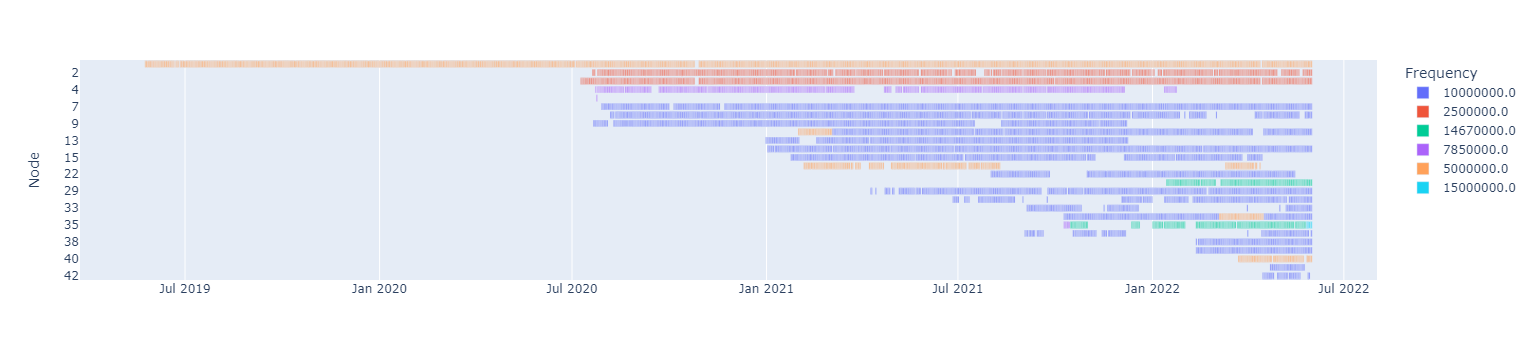

In [5]:
# We can create a Data Inventory (Gantt chart) showing when different stations were active. 
gantt = df.copy()

# List of logged nodes during the period of interest, for sorting:
logged_nodes = df["Node"].unique().tolist()
logged_nodes.sort()

gantt.set_index('Node')
gantt = gantt.drop(columns=['G', 'Grid Square'])
gantt['EndTime'] = gantt['Datetime']+ datetime.timedelta(days=1) # create an end
gantt['Filename'].str.strip('FRQ_')

fig = px.timeline(gantt, x_start="Datetime", x_end="EndTime", y="Node", color="Frequency", category_orders={"Node": logged_nodes})
fig.update_yaxes(type='category')
fig.update_annotations(text = "Filename", clicktoshow='on')
fig.show()

fig.write_html("gantt.html", include_plotlyjs="cdn")

In [6]:
# Read in node list:
nodes = pd.read_csv ('nodelist.csv',  encoding='cp1252')
nodes = nodes[1:42] # discarding extra rows - this should be dynamically assigned, but is manual for now.
nodes = nodes.rename(columns={'Node #': 'Node_Number'})
nodes = nodes.set_index('Node_Number')

nodes['Status'] = np.where((nodes.index.isin(logged_nodes)), "Data logged", "No data logged")

# Highlight rows in green for stations that we have data from.
color = (nodes['Status'] == 'Data logged').map({True: 'background-color: palegreen', False: ''})
nodes.style.apply(lambda s: color)

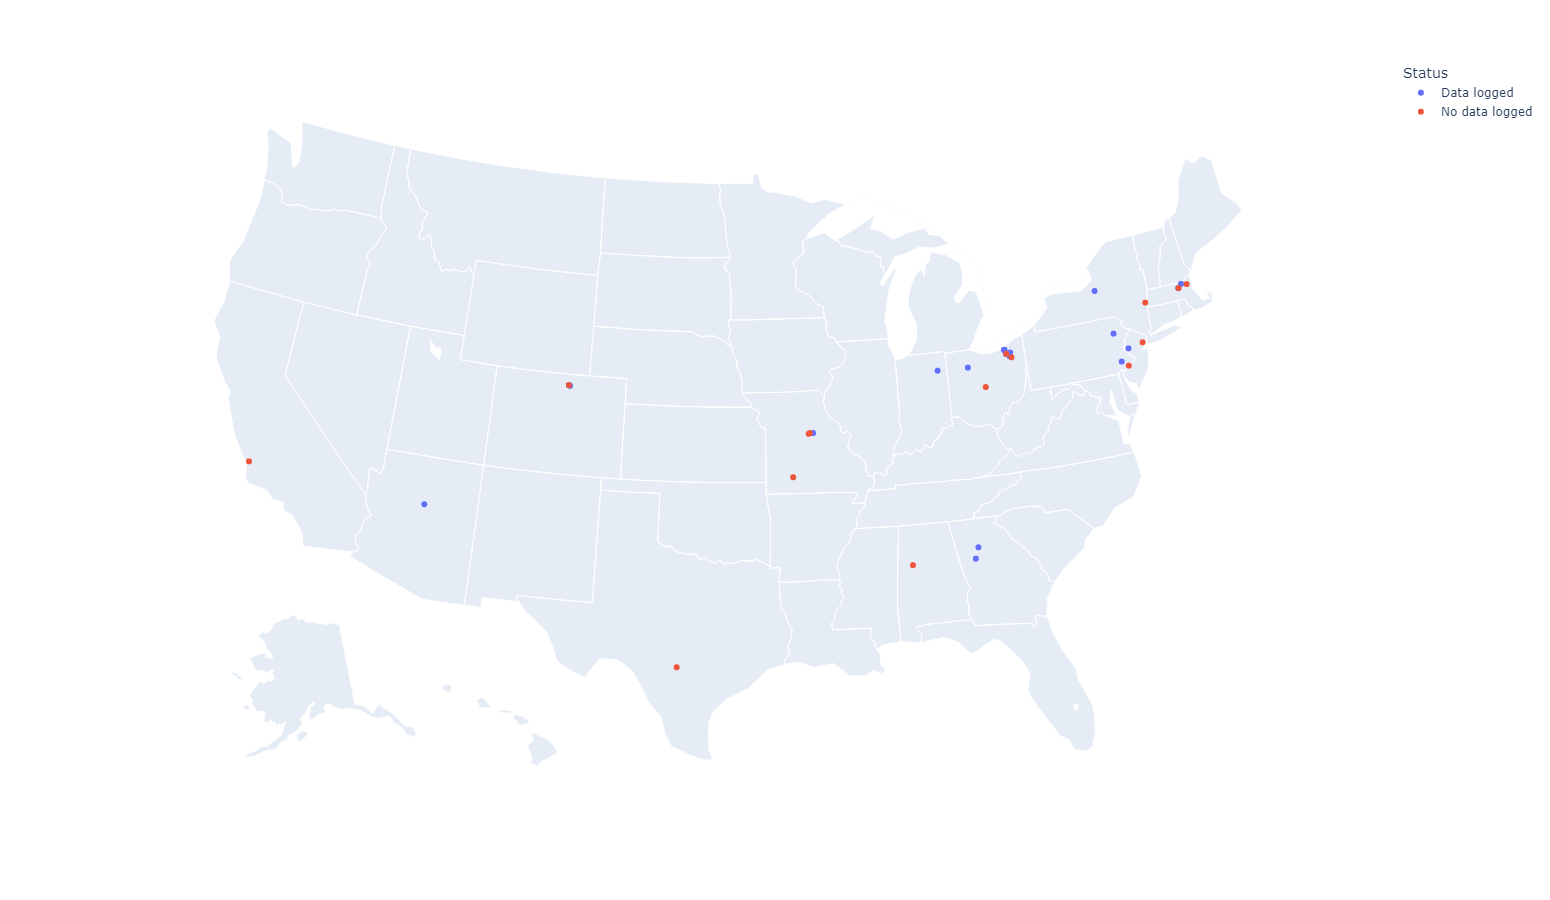

In [7]:
# Map nodes:
fig = px.scatter_geo(nodes, "Latitude", "Longitude",
                     color="Status", # which column to use to set the color of markers
                     hover_name=nodes["Callsign"], # column added to hover information
                     projection = 'albers usa',
                     width = 1200, height = 900,
                     )

fig.show()

## Example of a concurrent daily plot
Let's use the multiplot function developed by Bob Benedict KD8CGH (https://github.com/rkayakr/ProcessPlot) to plot Grape data from multiple stations on the same date. October 28, 2021 is a good example date, because there were solar flares widely observed by Grape 1 stations.

The `multiplot` function is adapted from KD8CGH's code. It checks a text file in the local directory for the set of files to plot. We'll define the function, then make a list of files and call it. 

This version of `multiplot()` also makes it easy to plot the sunrise and sunset times for a given station, or add a vertical line at the time of an event. By default, these functions are not enabled. 

In [8]:
def multiplot(plotTitle = ' Grape Data Plot', plot_sun = False, plot_event = False, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare'):
    '''
    PROCESSED FILE VERSION V1.0 built on multiPlot v1.2
    multiPlot version v1.2 cleans up to make Pi and Windows use easier
    multiPlot version v1.1 adds sunrise sunset times for location of lat long in first file
    requires suntime library https://github.com/SatAgro/suntime
    multiPlot version v1.0 plots up to 10 PSWS "rawdata" files and average value
    modified from WWV_plt2.py @authors dkazdan jgibbons
    expects a homepath directory with processed files in homepath or subdirs 
    leaves plot in Mplot directory
    plots files from multiple subdir to compare node results
    plot title from first file
    windows version hardcoded homepath directory location
    for Pi comment out windows homepath and uncomment Pi  lines
    uses WWV_utility2.py
    Bob Benedict, KD8CGH, 7/29/2021
    create text file "plotfiles.txt" in homepath directory
      keyword ('Doppler' or 'Power')
      keyword ('Average' or 'No Average')
      subdir/filename1 
      subdir/filename2
      filename3
      ...
    Note - expects all data from the same beacon
    if found 'Doppler' will plot Doppler shifts, else will plot Power
    if found "Average" will add average plot
    loads file names in list
    plots first file and create axis and title info
    plots rest in loop as curves on first plot
    calculates average and plots
    leaves plotfile in Mplot directory
    uses
    WWV_utility2.py
    20 February 2020
    WWV utility file
    Routines and classes used in WWV file management and graphing
    David Kazdan, AD8Y
    John Gibbons, N8OBJ - mods to plot header 2/3/20
    '''


    '''  #uncomment for Pi
    # ~ points to users home directory - usually /home/pi/
    homepath = os.path.expanduser('~')
    # embed the trailing / in the home path
    homepath = homepath + "/PSWS/"
    #comment out windows homepath
    '''

    homepath = ""#E:\\Documents\\PSWS\\"  # set your windows path, comment out for Pi

    names = open(homepath+"Processfiles.txt","r")

    PlotTarget = names.readline()
    PlotTarget = PlotTarget.strip('\n')
    PlotAverage = names.readline()
    if PlotAverage[0:7] == 'Average':
        doavg=True
    else:
        doavg=False

    Filenames=['a' for a in range (10)]
    Filedates=['a' for a in range (10)]
    #PrFilenames=['a' for a in range (10)]
    Nodenum=['a' for a in range (10)]
    Beaconname=['a' for a in range (10)]
    beaconfreq=np.zeros(10)

    nfiles = 0  # holder for number of files to plot

    colors=['b','g','r','c','m','y','tab:orange','tab:gray','tab:purple','tab:brown']

    while True:
        temp = names.readline()
        if  len(temp) <= 1:
            break
        Filenames[nfiles]=temp.strip("\n")
        fdate = Filenames[nfiles].find("/") # find start of filename after subdirectory
        if fdate==-1 :  # if / not found try \
            fdate = Filenames[nfiles].find("\\")
    #    print(" position ",fdate)
        # if neith / nor \ found file is in homepath, fdate=-1, following assignment still works
        Filedates[nfiles]=temp[fdate+1:fdate+11]
        nfiles=nfiles + 1

    print(Filenames[0:9])
    #print(Filedates[0:9])
    print('number of files',nfiles)
    if nfiles > 10 :
        print('10 file limit')
        sys.exit(0)

    PROCESSDIR = homepath

    #saved plot directory
    PlotDir = homepath + 'Mplot/'

    '''
    read first file
    '''
    PrFilenames=(PROCESSDIR + Filenames[0])

    if (os.path.exists(PrFilenames)):
        print('File ' + PrFilenames + ' found!\nProcessing...')
    else:
        print('File ' + PrFilenames + ' not available.\nExiting disappointed...')
        sys.exit(0)

    with open(PrFilenames, 'r') as dataFile:
        dataReader=csv.reader(dataFile)
        data = list(dataReader)
        Header = data.pop(0)

    #    print('return',readheader(0,Header))
        Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[0], Beaconname[0], beaconfreq[0], Lat, Long, '\n')

    ''' ###########################################################################
    '''
    print('Ready to start processing records')

    # Prepare data arrays
    hours=[[],[],[],[],[],[],[],[],[],[]]
    Doppler=[[],[],[],[],[],[],[],[],[],[]]
    #Vpk=[[],[],[],[],[],[],[],[],[],[]]
    Power_dB=[[],[],[],[],[],[],[],[],[],[]] # will be second data set, received power 9I20
    filtDoppler=[[],[],[],[],[],[],[],[],[],[]]
    filtPower=[[],[],[],[],[],[],[],[],[],[]]

    LateHour=False # flag for loop going past 23:00 hours

    # eliminate all metadata saved at start of file - Look for UTC (CSV headers)
    #find first row of data0
    FindUTC = 0

    for row in data:
        if (FindUTC == 0):
            #print('looking for UTC - row[0] =',row[0])
            if (row[0] == 'UTC'):
                FindUTC = 1
    #            print('UTC found =', row[0])
        else:
            #print('Processing record')
            decHours=time_string_to_decimals(row[0])
    #        if (NewHdr != 'New'):
    #            if (calccnt  < 101):
    #                calcnt = calcnt+1
    #                freqcalc = freqcalc + (float(row[1])/100)
    #        if decHours > 23:
    #            LateHour=True # went past 23:00 hours
            if (not LateHour) or (LateHour and (decHours>23)): # Otherwise past 23:59:59.  Omit time past midnight.
                hours[0].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[0].append(float(row[1])-beaconfreq[0]) # frequency offset from col 2
    #            Vpk[0].append (float(row[2])) # Get Volts peak from col 3
                Power_dB[0].append (20*np.log10(float(row[2]))) # log power from col 4

    #print('nf ',0,'len hours',len(hours[0]))

    ###############################################################################################
    # Find max and min of Power_dB for graph preparation:
    min_power=np.amin(Power_dB[0]) # will use for graph axis min
    max_power=np.amax(Power_dB[0]) # will use for graph axis max

    min_Doppler=np.amin(Doppler[0]) # min Doppler
    max_Doppler=np.amax(Doppler[0]) # max Doppler

    print('\nDoppler min: ', min_Doppler, '; Doppler max: ', max_Doppler)
    print('dB min: ', min_power, '; dB max: ', max_power)

    #%% Create an order 3 lowpass butterworth filter.
    # This is a digital filter (analog=False)
    # Filtering at .01 to .004 times the Nyquist rate seems "about right."
    # The filtering argument (Wn, the second argument to butter()) of.01
    # represents filtering at .05 Hz, or 20 second weighted averaging.
    # That corresponds with the 20 second symmetric averaging window used in the 1 October 2019
    # Excel spreadsheet for the Festival of Frequency Measurement data.
    #FILTERBREAK=.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
    FILTERORDER=6
    b, a = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')
    #print (b, a)
    #%%
    # Use the just-created filter coefficients for a noncausal filtering (filtfilt is forward-backward noncausal)


    filtDoppler[0] = filtfilt(b, a, Doppler[0])

    filtPower[0] = filtfilt(b, a, Power_dB[0])

    ##################################################################################################
    # sunrise sunset times in UTC
    sun = Sun(float(Lat), float(Long))

    UTC_DT=Filedates[0]
    print(UTC_DT)
    SDAY=int(UTC_DT[8:10])
    SMON=int(UTC_DT[5:7])
    SYEAR=int(UTC_DT[0:4])
    sdate = datetime.date(SYEAR, SMON, SDAY)
    event = parser.parse(eventTime)                              # Event time is parsed
    print(event)
    evh=int(format(event.strftime('%H')))                        # ...take the hour....
    evm=int(format(event.strftime('%M')))                        #.........and the minute...
    evx=evh+evm/60                                               # ...to find where the vertical line goes on the plot.
    today_sr = sun.get_sunrise_time(sdate)
    today_ss = sun.get_sunset_time(sdate)
    srh=int(format(today_sr.strftime('%H')))
    srm=int(format(today_sr.strftime('%M')))
    srx=srh+srm/60
    ssh=int(format(today_ss.strftime('%H')))
    ssm=int(format(today_ss.strftime('%M')))
    ssx=ssh+ssm/60

    # set up x-axis with time
    fig = plt.figure(figsize=(19,10)) # inches x, y with 72 dots per inch
    ax = fig.add_subplot(111)
    ax.set_xlabel('UTC Hour')
    ax.set_xlim(0,24) # UTC day
    ax.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24], minor=False)

    # plot first curve
    if (PlotTarget == 'Doppler'):
        if plot_sun == True:
            ax.plot([srx,srx],[-1,1],'y',label='Sunrise: ' + str(today_sr), linestyle='dashed')      # plot sunrise for first station
            ax.plot([ssx,ssx],[-1,1],'b',label='Sunset: '  + str(today_ss), linestyle='dashed')       # sunset for first station
        if plot_event == True:
            print('Plotting event: ' + eventlabel + ' at ' + str(event))
            ax.plot([evx,evx],[-1,1],'k',label=eventlabel + ' at ' + str(event),linestyle='dashed')
        ax.plot(hours[0], filtDoppler[0], colors[0],label=Beaconname[0] +' '+Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Doppler shift, Hz '+ Filedates[0])
        ax.set_ylim([-1.0, 1.0]) # -1 to 1 Hz for Doppler shift
        plt.axhline(y=0, color="gray", lw=1) # plot a zero freq reference line for 0.000 Hz Doppler shift


    else:                                 # Plotting power:
        if plot_sun == True:
            ax.plot([srx,srx],[-90, 0],'y',label='Sunrise: ' + str(today_sr), linestyle='dashed')      # plot sunrise for first station
            ax.plot([ssx,ssx],[-90, 0],'b',label='Sunset: '  + str(today_ss), linestyle='dashed')       # sunset for first station
        if plot_event == True:
            print('Plotting event: ' + eventlabel + ' at ' + str(event))
            ax.plot([evx,evx],[-90, 0],'k',label=eventlabel + ' at ' + str(event),linestyle='dashed')
        ax.plot(hours[0], filtPower[0], colors[0],label=Beaconname[0] +' '+ Nodenum[0]+' '+Filedates[0]) # color k for black
        ax.set_ylabel('Power, dB '+ Filedates[0])
        ax.set_ylim(-90, 0)    


    # add grid lines - RLB
    plt.grid(axis='both')

    '''
    ######################################################################
    read and plot files loop
    '''

    for nf in range(1, nfiles):
    # splot second curve
    # read second file, skip header
        print('process file ',nf, Filenames[nf])
        PrFilenames=(PROCESSDIR + Filenames[nf])
        with open(PrFilenames, 'r') as dataFile: # read second set
            dataReader=csv.reader(dataFile)
            data = list(dataReader)
            Header = data.pop(0)
            Nodenum[nf]= Header[2]
        FindUTC = 0

        Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long = readheader(Header)
    #    print('\n returned ', Nodenum[nf], Beaconname[nf], beaconfreq[nf], Lat, Long, '\n')

        for row in data:
            if (FindUTC == 0):
                #print('looking for UTC - row[0] =',row[0])
                if (row[0] == 'UTC'):
                    FindUTC = 1
    #            print('UTC found =', row[0])
            else:
                decHours=time_string_to_decimals(row[0])
                hours[nf].append(decHours) # already in float because of conversion to decimal hours.
                Doppler[nf].append(float(row[1])-beaconfreq[nf]) # frequency offset from col 2
    #            Vpk[nf].append (float(row[2])) # Get Volts peak from col 3
    #            Power_dB[nf].append (float(row[4])) # log power from col 4    
                Power_dB[nf].append (20*np.log10(float(row[2]))) # log power
    # filter  file data
        filtDoppler[nf] = filtfilt(b, a, Doppler[nf])
        filtPower[nf] = filtfilt(b, a, Power_dB[nf])

        if (PlotTarget == 'Doppler'):    
            ax.plot(hours[nf], filtDoppler[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black
        else:
            ax.plot(hours[nf], filtPower[nf], colors[nf], label=Beaconname[nf] +' '+ Nodenum[nf]+' '+Filedates[nf]) # color k for black

    '''
    #############################################################################
    end for read and plot loop, start average
    '''
    # find shortest data set, limit average to that
    if doavg :
        al=1000000
        ak=0

        for k in range(nfiles):
            templ=len(hours[k])
            if templ < al:
                al=templ
                ak=k

        avg=[]

        if (PlotTarget == 'Doppler'):
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtDoppler[j][i]
                temp=temp/nfiles
                avg.append(temp)
        else:
            for i in range(al):
                temp=0.0
                for j in range(nfiles):
                    temp=temp+filtPower[j][i]
                temp=temp/nfiles
                avg.append(temp)

        #print('avg',len(avg))

        ax.plot(hours[ak], avg, 'k', label='Average') # color k for black

    '''
    end average
    '''
    ax.legend(loc="lower right",  frameon=False)


    # Create Plot Title
    plt.title(plotTitle)
    #plt.title(beaconlabel + ' Grape Data Plot\nNode:  ' + node + '     Gridsquare:  '+ GridSqr + '\nLat= ' + Lat + '    Long= ' + Long + '    Elev= ' + Elev + ' M\n' )
    # Create Plot File Nam
    #GraphFile = yesterdaystr + '_' + node + '_' + RadioID + '_' + GridSqr + '_' + beacon + '_graph.png'
    GraphFile = 'multi'+ PlotTarget + '.png'
    PlotGraphFile = PlotDir + GraphFile

    # create plot
    #plt.savefig(PlotDir + yesterdaystr + '_' + node + '_' +  GridSqr + '_' +  RadioID + '_' +  beacon + '_graph.png', dpi=250, orientation='landscape')
    plt.savefig(PlotDir + GraphFile, dpi=250, orientation='landscape')
    # =============================================================================

    print('Plot File: ' + GraphFile + '\n')  # indicate plot file name for crontab printout

    return fig
    #-------------------------------------------------------------------
    print('Exiting python multi plot program gracefully')

We'll make a list of files:

['data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv', 'a', 'a', 'a', 'a', 'a']
number of files 4
File data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

Ready to start processing records

Doppler min:  -2.044999999925494 ; Doppler max:  1.9660000000149012
dB min:  -92.39577516576787 ; dB max:  -60.44552789422305
2021-10-28
2021-10-28 15:35:00+00:00
process file  1 data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

process file  2 data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV 

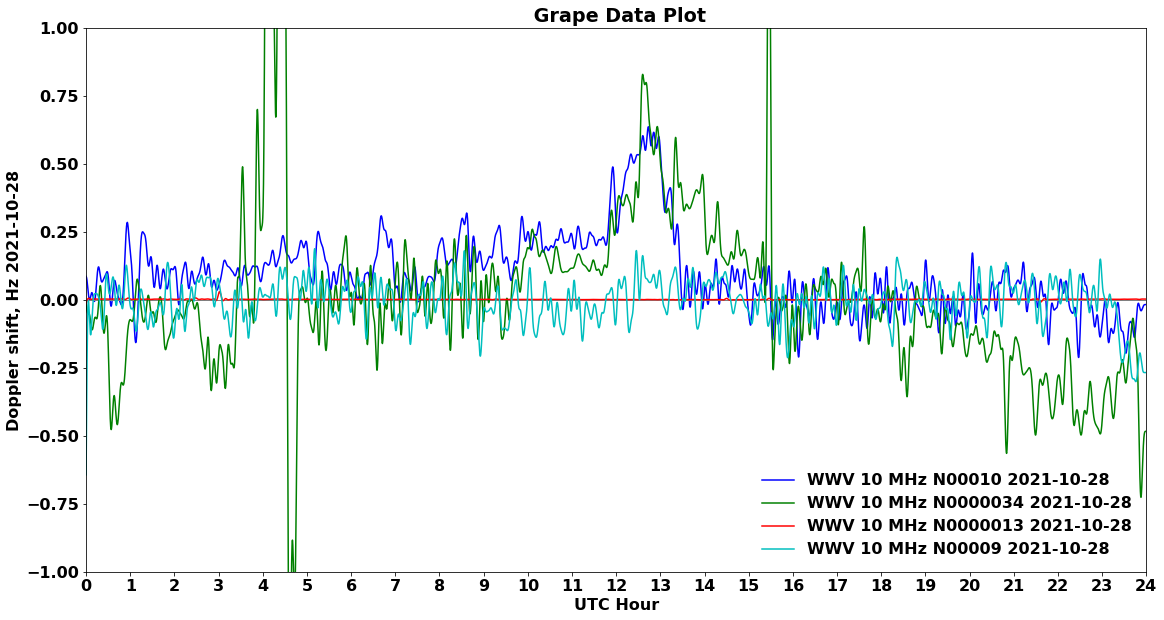

In [9]:
def gather(gantt = df, Freq = 10e6, start = [2018, 1, 1, 0, 0, 0], end = [datetime.date.today().year, datetime.date.today().month, datetime.date.today().day]):
    plotfiles = gantt.loc[gantt['Frequency'] == Freq]                        # only a specific frequency...
    sTime_tmp = datetime.datetime(start[0], start[1], start[2], tzinfo = pytz.UTC)
    eTime_tmp = datetime.datetime(end[0], end[1], end[2], tzinfo = pytz.UTC)
    namelist = plotfiles[(plotfiles['Datetime'] >= sTime_tmp) & (plotfiles['Datetime'] <= eTime_tmp)].Filename
    return namelist


def listsave(names, listname = "Processfiles.txt", path = 'data/', plot_Power = False, plot_Average = False):
    textfile = open(listname, "w")                             # write list to text file for multiplot, below
    if plot_Power:
        textfile.write('Power' +  "\n")
    else:
        textfile.write('Doppler' +  "\n")
    if plot_Average:
        textfile.write('Average' +  "\n")
    else:
        textfile.write('No Average' +  "\n")
    for element in names:
        textfile.write(path+element +  "\n")
    textfile.close()


# Note: the multiplot routine will only work for a single day's worth of data.
namelist = gather(gantt=df, start = [2021, 10, 28], end = [2021, 10, 28])
names=namelist.values.tolist()
names = names[0:4]                                                   # select specific rows...
listsave(names, plot_Power = False, plot_Average = False)              # Example 

names

# # ....and plot:
foo = multiplot()

Let's add a line for that solar flare:

['data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv', 'data/2021-10-28T000000Z_N00009_G1_FN20ge_FRQ_WWV10.csv', 'a', 'a', 'a', 'a', 'a']
number of files 4
File data/2021-10-28T000000Z_N00010_G1_EN91ii_FRQ_WWV10.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

Ready to start processing records

Doppler min:  -2.044999999925494 ; Doppler max:  1.9660000000149012
dB min:  -92.39577516576787 ; dB max:  -60.44552789422305
2021-10-28
2021-10-28 15:35:00+00:00
Plotting event: X1 Class Solar Flare at 2021-10-28 15:35:00+00:00
process file  1 data/2021-10-28T000000Z_N0000034_G1_FN13wd_FRQ_WWV10.csv
New Header String Detected

corrected UTCDTZ = 2021-10-28T000000Z
Plot for Decoded 10MHz WWV Beacon

process file  2 data/2021-10-28T000000Z_N0000013_S1_DN70ln_FRQ_WWV10.csv
New Header String Detected


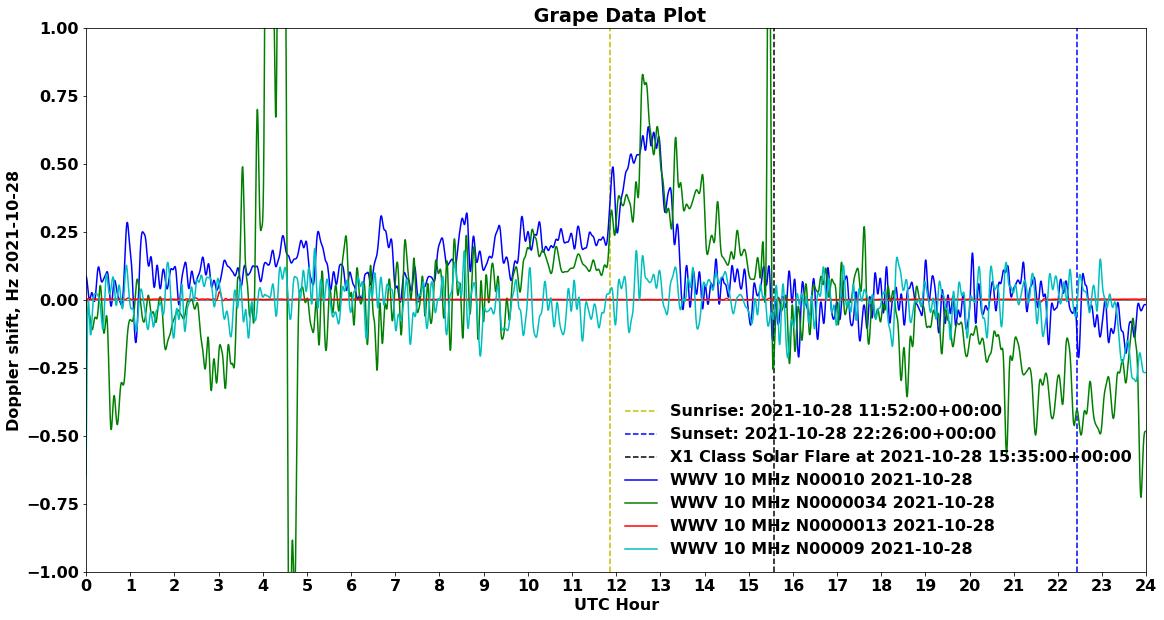

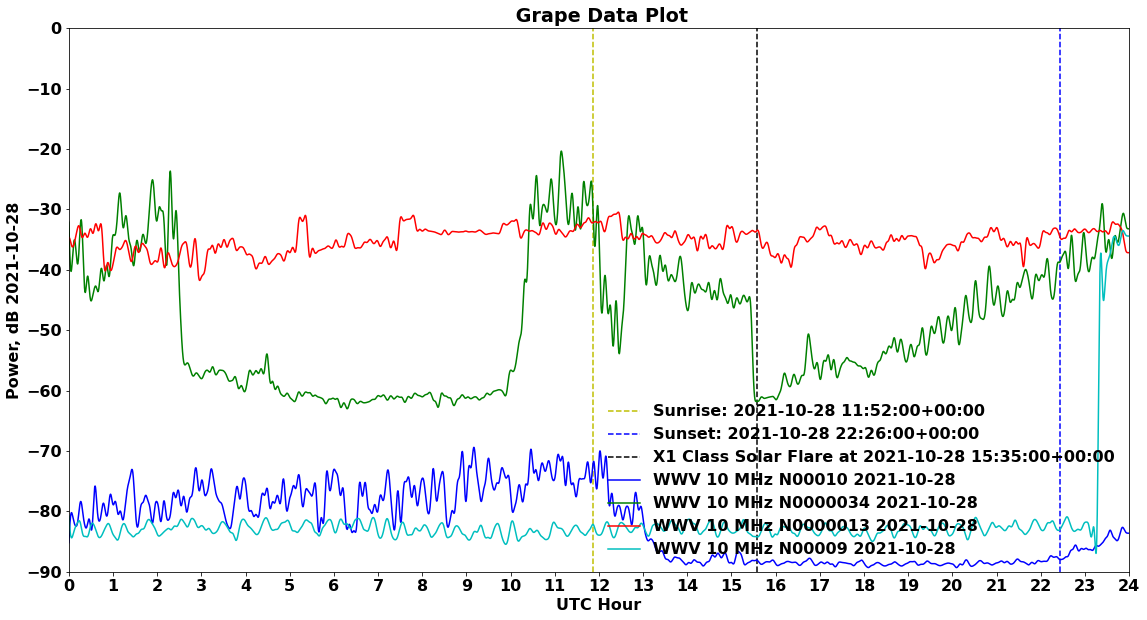

In [10]:
namelist = gather(gantt=df, start = [2021, 10, 28], end = [2021, 10, 28])
names=namelist.values.tolist()
names = names[0:4]                                                   # select specific rows...

listsave(names, plot_Power = False, plot_Average = False)              # Example 
foo = multiplot(plot_sun = True, plot_event = True, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare')

listsave(names, plot_Power = True, plot_Average = False)              # Example 
foo = multiplot(plot_sun = True, plot_event = True, eventTime = '2021-10-28 15:35:00+00:00', eventlabel = 'X1 Class Solar Flare')

We can also use the multiplot function to plot data for a single station by restricting the `names`, and automatically compute the sunrise and sunset times for that station. Check out Figure 12 here for more information about this: https://www.hardware-x.com/article/S2468-0672(22)00034-7/fulltext#secst075

If more than one day is included, or more than one station, the sunrise and sunset calculations will be made for the first day and station appearing in the list. Here's an example of two concurrent days of data from N8OBJ, plotted on top of one another: 

['data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
number of files 2
File data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv found!
Processing...
New Header String Detected

corrected UTCDTZ = 2019-10-01T000000Z
Plot for Decoded 5MHz WWV Beacon

Ready to start processing records

Doppler min:  -7.13399999961257 ; Doppler max:  6.599000000394881
dB min:  -43.40620718202058 ; dB max:  -7.4557152645529525
2019-10-01
2021-10-28 15:35:00+00:00
process file  1 data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv
New Header String Detected

corrected UTCDTZ = 2019-10-02T000000Z
Plot for Decoded 5MHz WWV Beacon

Plot File: multiDoppler.png

['data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'data/2019-10-02T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv', 'a', 'a', 'a', 'a', 'a', 'a', 'a']
number of files 2
File data/2019-10-01T000000Z_N0000001_G1_EN91fh_FRQ_WWV5.csv found!
Processi

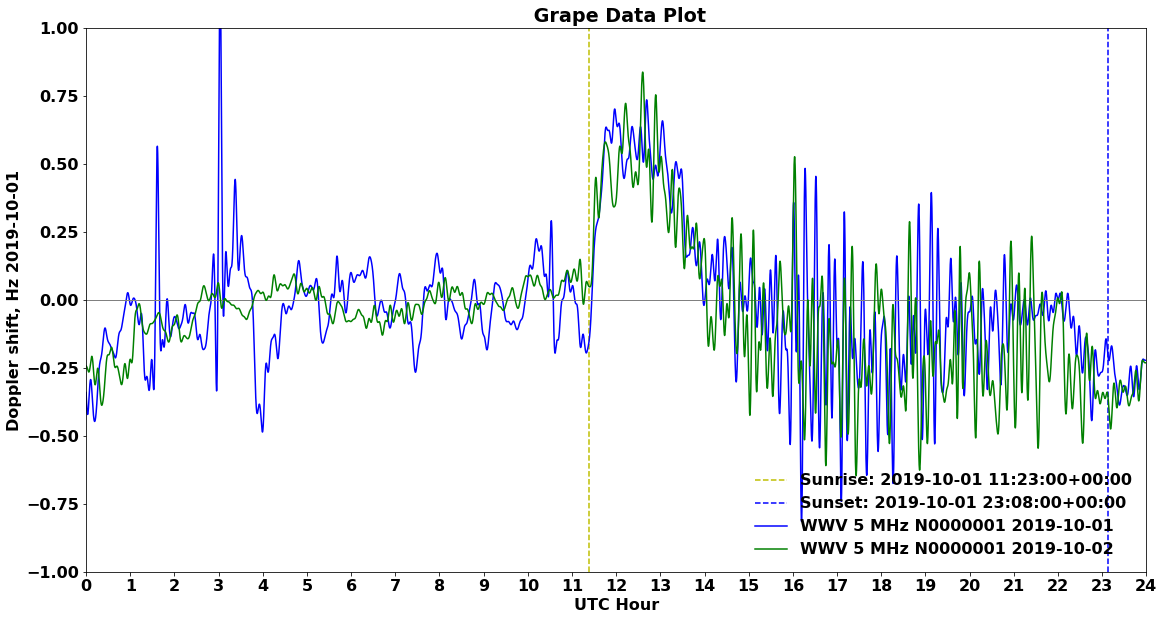

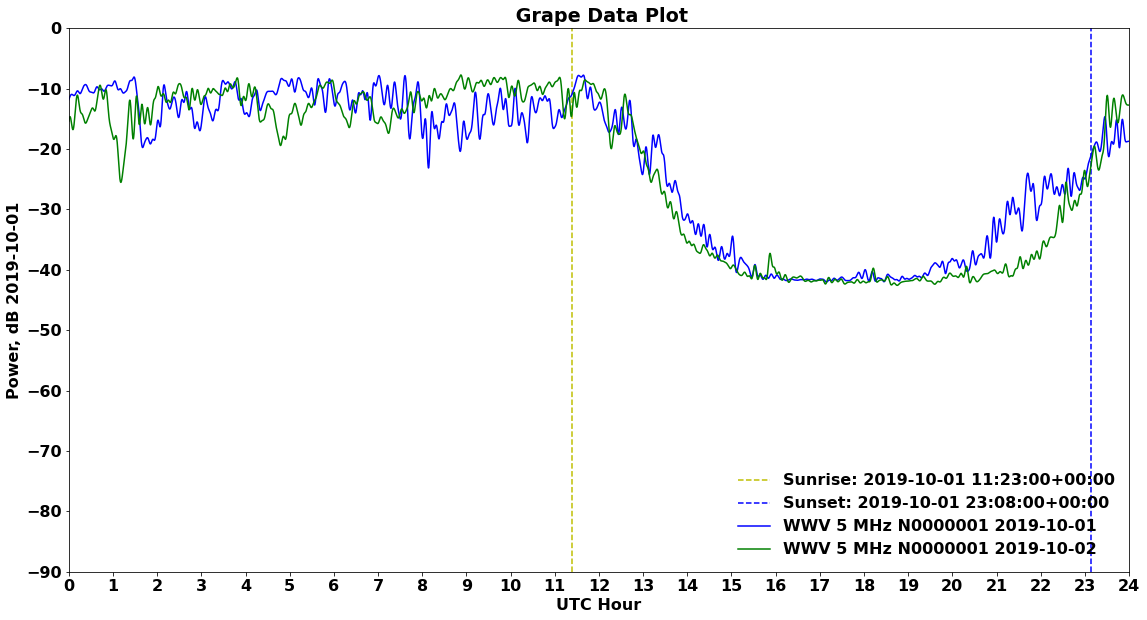

In [11]:
namelist = gather(gantt=df, Freq = 5e6, start = [2019, 10, 1], end = [2019, 10, 2])
names=namelist.values.tolist()
# names = names[0:1]                                                   # select specific rows...
listsave(names, plot_Power = False, plot_Average = False)              # Example 

# ....and plot:
foo = multiplot(plot_sun = True)

listsave(names, plot_Power = True, plot_Average = False)              # Example 
# ....and plot:
foo = multiplot(plot_sun = True)


In [15]:
sTime = datetime.datetime(2021,10,28, tzinfo=pytz.UTC)
eTime = sTime + datetime.timedelta(hours=24)
freq  = 10e6 # MHz

# Make temporary copy of dataframe.
dft   = df.copy()

# Select rows with selected frequency
tf    = dft['Frequency'] == freq
dft   = dft[tf].copy()

# Select rows matching time range.
tf    = np.logical_and(dft['Datetime'] >= sTime, dft['Datetime'] < eTime)
dft   = dft[tf].copy()

node_nrs = dft['Node'].unique()
node_nrs.sort()

data  = {} # Initialize dictionary to hold all data.
# Loop through nodes and load into a data frame.
for node in node_nrs:
    tf = dft['Node'] == node
    df_node = dft[tf].copy()
    
    # Generate a label for each Node
    call_sign = nodes.loc[node,'Callsign']    
    label     = '{:0.1f} MHz N{:07d} {!s}'.format(freq/1e6,node,call_sign)
    
    # Get latitude and longitude
    lat = nodes.loc[node,'Latitude']
    lon = nodes.loc[node,'Longitude']
    
    # Load data from every data file available for node/frequency/date range.
    df_raw = None
    for rinx,row in df_node.iterrows():
        fname = row['Filename']
        fpath = os.path.join(mypath,fname)
        
        df_load = pd.read_csv(fpath, comment = '#', parse_dates=[0])

        # Remove the center frequency offset from the frequency column.
        df_load['Freq'] = df_load['Freq']-freq
        if df_raw is None:
            df_raw = df_load.copy()
        else:
            df_raw = df_load.copy()
            df_raw = pd.concat([df_data,df_load],ignore_index=True)
        
        df_raw = df_raw.sort_values('UTC')
    
    # Convert Vpk to Power_dB
    df_raw['Power_dB'] = 20*np.log10(df_raw['Vpk'])
    
    # Store data into dictionaries.
    tmp = {}
    tmp['df_raw'] = df_raw
    tmp['label']  = label
    tmp['lat']    = lat
    tmp['lon']    = lon
    
    data[node] = tmp

# Create an order 3 lowpass butterworth filter.
# This is a digital filter (analog=False)
# Filtering at .01 to .004 times the Nyquist rate seems "about right."
# The filtering argument (Wn, the second argument to butter()) of.01
# represents filtering at .05 Hz, or 20 second weighted averaging.
# That corresponds with the 20 second symmetric averaging window used in the 1 October 2019
# Excel spreadsheet for the Festival of Frequency Measurement data.
FILTERBREAK=0.005 #filter breakpoint in Nyquist rates. N. rate here is 1/sec, so this is in Hz.
FILTERORDER=6
b, a = butter(FILTERORDER, FILTERBREAK, analog=False, btype='low')

# Apply filter
for node, grape_dct in data.items():
    df_raw  = grape_dct['df_raw']
    df_filt = df_raw.copy()
        
    # Use the filter coefficients for a noncausal filtering (filtfilt is forward-backward noncausal)
    df_filt.loc[:,'Freq']     = filtfilt(b, a, df_filt['Freq'])
    df_filt.loc[:,'Vpk']      = filtfilt(b, a, df_filt['Vpk'])
    df_filt.loc[:,'Power_dB'] = filtfilt(b, a, df_filt['Power_dB'])
    
    grape_dct['df_filt'] = df_filt

/tmp/ipykernel_1856730/2606067471.py:76: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/tmp/ipykernel_1856730/2606067471.py:76: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



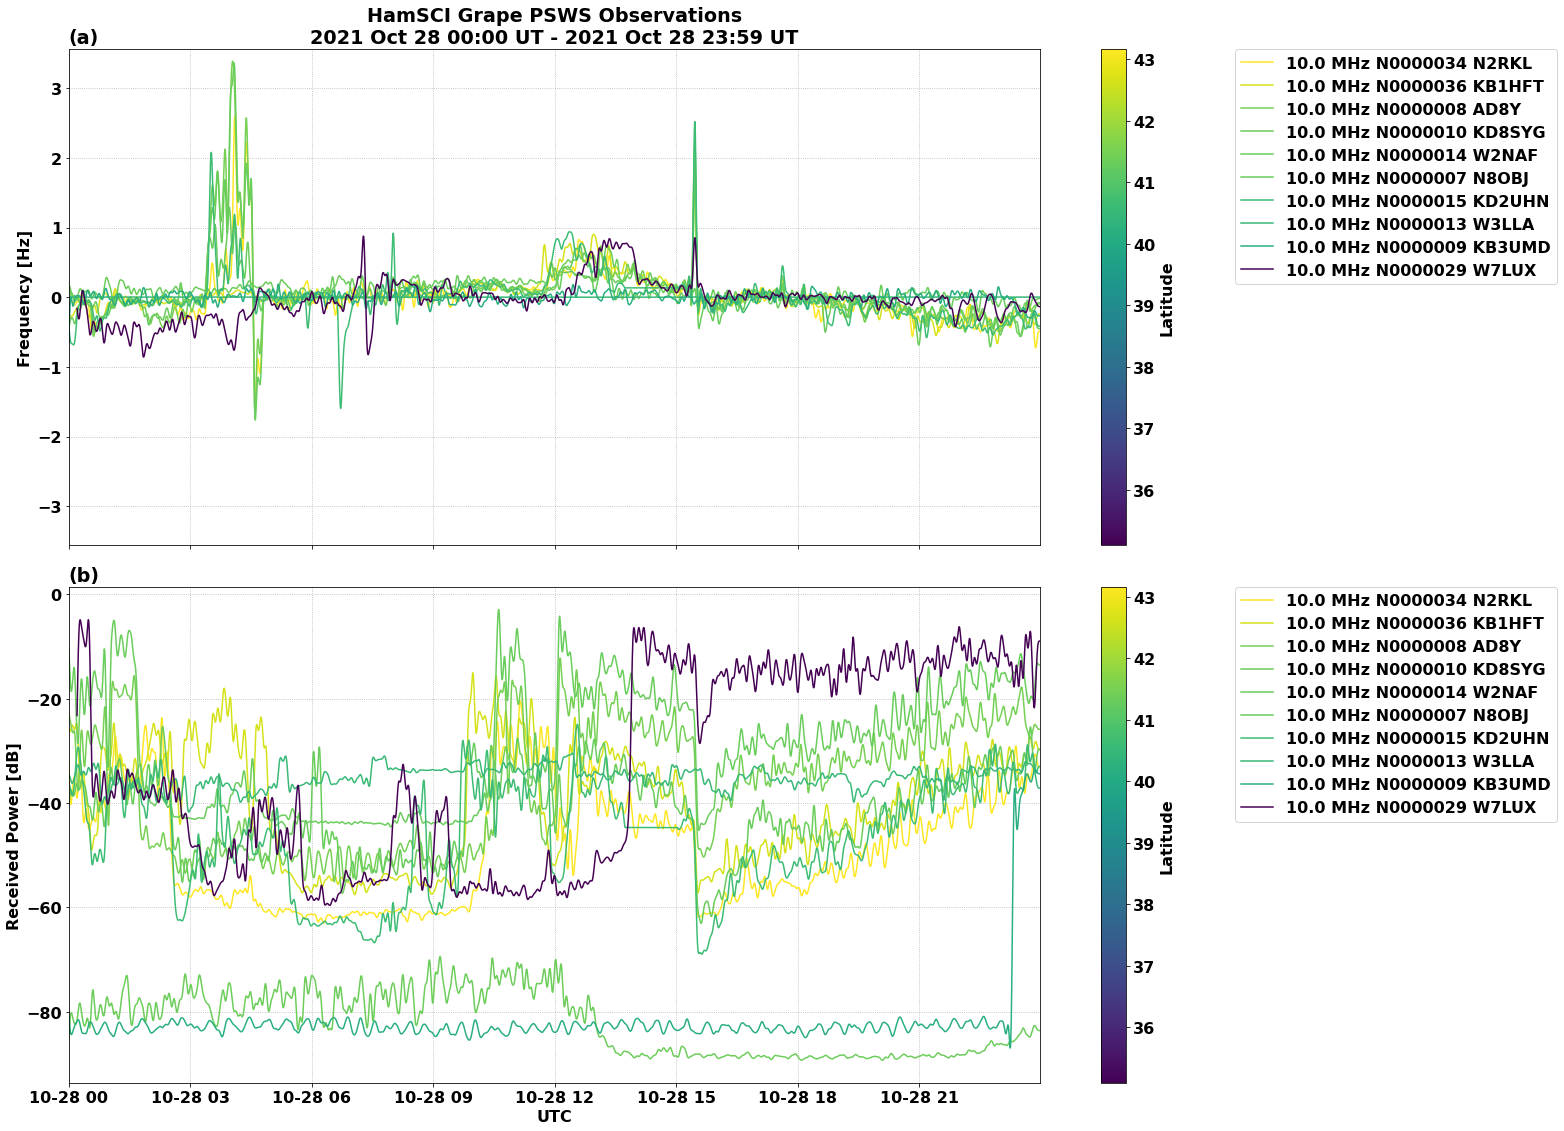

/tmp/ipykernel_1856730/2606067471.py:76: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

/tmp/ipykernel_1856730/2606067471.py:76: MatplotlibDeprecationWarning:

Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.



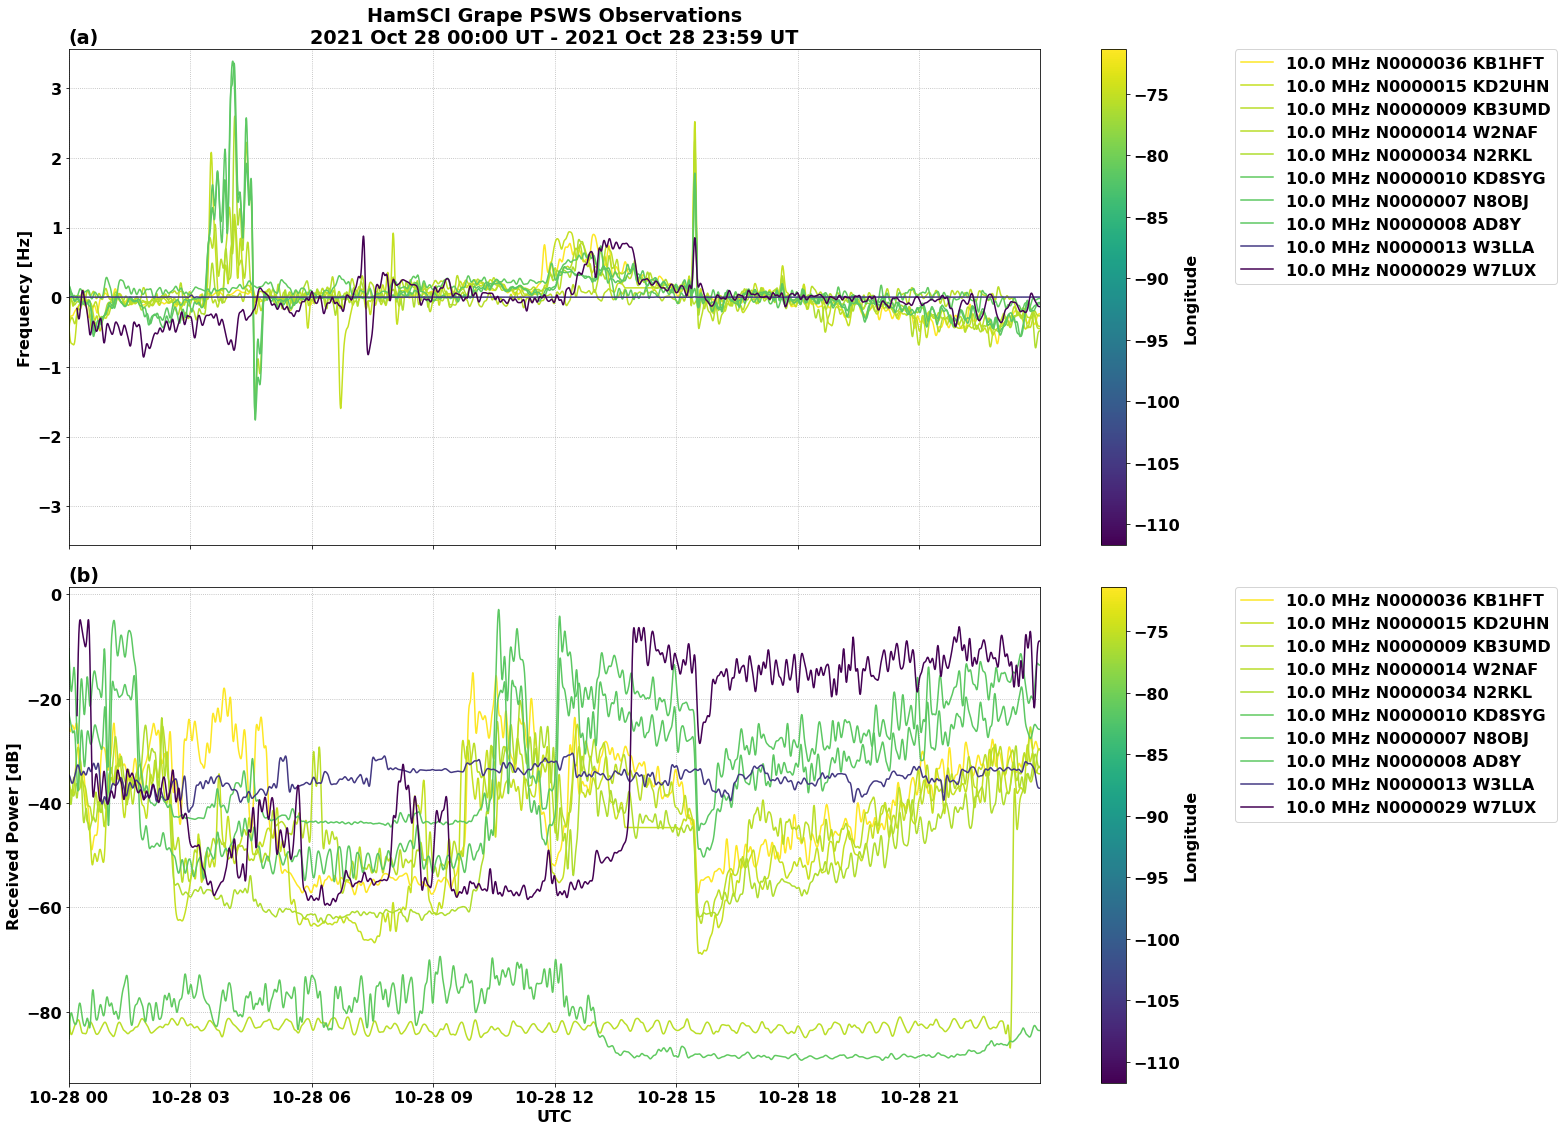

In [19]:
def multiplot(data,sDate=None,eDate=None,
              plt_dcts=None,color_dct=None,legend=True,
              fig_width=22,panel_height=8):
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    if plt_dcts is None:
        plt_dcts = {}

        plt_key = 'Freq'
        plt_dcts[plt_key] = dct = {}
        dct['label']      = 'Frequency [Hz]'

        plt_key = 'Power_dB'
        plt_dcts[plt_key] = dct = {}
        dct['label']      = 'Received Power [dB]'

    if color_dct is not None:
        ckey = color_dct.get('ckey')
        
        # Sort data by ckey.
        data = {k: v for k, v in sorted(data.items(), key=lambda item: item[1][ckey],reverse=True)}
        vals = [x[ckey] for x in data.values()]
        
        cmap = color_dct.get('cmap','viridis')
        vmin = color_dct.get('vmin',np.min(vals))
        vmax = color_dct.get('vmax',np.max(vals))
        
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        mpbl = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        
    ncols = 1
    nrows = len(plt_dcts)

    figsize = (fig_width, nrows*panel_height)
    fig     = plt.figure(figsize=figsize)

    for plt_inx,(plt_key, plt_dct) in enumerate(plt_dcts.items()):
        ax   = fig.add_subplot(nrows, ncols, plt_inx+1)

        xx_xtrm   = [] # Keep track of time extrema.
        abs_maxes = [] # Keep track of absolute value maxima
        for node,grape_dct in data.items():
            df_data = grape_dct['df_filt']
            label   = grape_dct['label']
            
            plt_kw  = {}

            xx      = df_data['UTC']
            yy      = df_data[plt_key]

            xx_xtrm.append(np.min(xx))
            xx_xtrm.append(np.max(xx))
            
            abs_maxes.append(np.nanmax(np.abs(yy)))
            if color_dct is not None:
                val     = grape_dct[ckey]
                plt_kw['color'] = mpbl.cmap(mpbl.norm(val))

            ax.plot(xx,yy,label=label,**plt_kw)

        if sDate is None:
            sDate = min(xx_xtrm)
            
        if eDate is None:
            eDate = max(xx_xtrm)
            
        ax.set_xlim(sDate,eDate)
        
        if plt_key == 'Freq':
            abs_max = np.max(abs_maxes)
            ax.set_ylim(-abs_max*1.05,abs_max*1.05)

        legend_bbox_to_anchor = (1.04,1)
        if color_dct is not None:
            clabel = color_dct.get('label')
            fig.colorbar(mpbl,ax=ax,label=clabel)
            legend_bbox_to_anchor = (1.2,1)
        
        if legend:
            ax.legend(bbox_to_anchor=legend_bbox_to_anchor, loc="upper left", borderaxespad=0)

        ylbl = plt_dct['label']
        ax.set_ylabel(ylbl)

        ax.set_title('({!s})'.format(letters[plt_inx]),loc='left')
        
        if plt_inx == 0:
            date_str = sDate.strftime('%Y %b %d %H:%M UT') + ' - ' + eDate.strftime('%Y %b %d %H:%M UT')            
            title = []
            title.append('HamSCI Grape PSWS Observations')
            title.append(date_str)
            ax.set_title('\n'.join(title))
        
        if plt_inx != nrows-1:
            
            ax.set_xticklabels('')
        else:
            ax.set_xlabel('UTC')
    
    fig.tight_layout()
    plt.show()
    
    return {'fig':fig}
    
##########################
color_dcts = {}

ckey = 'lat'
color_dcts[ckey] = dct = {}
dct['ckey']      = ckey
dct['label']     = 'Latitude'
# dct['vmin']      = 35
# dct['vmax']      = 45
#dct['cmap']      = 'cool'

ckey = 'lon'
color_dcts[ckey] = dct = {}
dct['ckey']      = ckey
dct['label']     = 'Longitude'

# multiplot(data)

cdct = color_dcts['lat']
fig  = multiplot(data,color_dct=cdct)

cdct = color_dcts['lon']
fig  = multiplot(data,color_dct=cdct)

In [14]:
np.sort([x['lat'] for x in data.values()])

array([35.09978 , 40.176   , 40.54323 , 40.63332 , 41.321963, 41.335116,
       41.352309, 41.493744, 42.637539, 43.163188])

## Keogram of long-term data
Let's generate a heatmap of one node's data to show trends over the long term.